In [1]:
from ldm import ldm

raw_data = ldm.get_experiment_measurements('exp2')

pos_neg_norm_data = ldm.normalize_values(raw_data, pos_neg_only=True)
pos_neg_norm_data_log = ldm.normalize_values(raw_data, pos_neg_only=True, log_value=True)

norm_data = ldm.normalize_values(raw_data)
norm_data_log = ldm.normalize_values(raw_data, log_value=True)

Processing plate BAF210901_9
Processing plate BAF210901_8
Processing plate BAF210901_7
Processing plate BAF210901_6
Processing plate BAF210901_5
Processing plate BAF210901_4
Processing plate BAF210901_3
Processing plate BAF210901_25
Processing plate BAF210901_24
Processing plate BAF210901_23
Processing plate BAF210901_22
Processing plate BAF210901_21
Processing plate BAF210901_20
Processing plate BAF210901_2
Processing plate BAF210901_19
Processing plate BAF210901_18
Processing plate BAF210901_17
Processing plate BAF210901_16
Processing plate BAF210901_15
Processing plate BAF210901_14
Processing plate BAF210901_13
Processing plate BAF210901_12
Processing plate BAF210901_11
Processing plate BAF210901_10
Processing plate BAF210901_1

Found 9600 measurements


In [2]:
z_prime = ldm.calculate_z_prime(raw_data)
z_prime_log = ldm.calculate_z_prime(raw_data, log_value=True)


In [3]:
%get raw_data
%get pos_neg_norm_data
%get pos_neg_norm_data_log
%get norm_data
%get norm_data_log
%get z_prime
%get z_prime_log

In [4]:
library(captioner)
library(RColorBrewer)
library(lawstat)
library(ggplot2)
library(dplyr)

library(ggpubr)
library(car)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ERROR: Error in library(ggpubr): there is no package called ‘ggpubr’


In [17]:
type.pal = brewer.pal(9,"Set1")
type.pal = c(type.pal[2:1], "black", type.pal[3:9], brewer.pal(8,"Dark2"))

create_qq_plot = function(data, title="Normal QQ Plot", pvar) {
    
    data$Control = as.factor(data$Control)    
    y = matrix(unlist(tapply(data$norm, data$Control, quantile, c(0.25,0.75), na.rm=T)), 
               ncol=2, byrow=T)
    x = qnorm( c(0.25, 0.75))         # Find the matching normal values on the x-axis
    slope = t(diff(t(y))) / diff(x)   # Compute the line slope
    int = y[,1] - slope * x[1]      
    qqline = data.frame(int=int, slope=slope, type=levels(droplevels(data$Control)))
    levels(qqline$type) = levels(data$Control)

    p = ggplot(data, aes(sample=norm, group=Control, color=Control)) + 
      stat_qq(distribution = qnorm) +
      #annotate(geom="text", x=0, y=min(data$norm), col="red", label=paste("Shapiro's Test p= ", pnorm), parse=F)+
      annotate(geom="text", x=0, y=(min(data$norm)+0.05), col="red", label=paste("Levine's Test p= ", pvar), parse=F)+
      geom_abline(data = qqline, aes(intercept=int, slope=slope)) + 
      scale_color_manual(name="", values=type.pal, drop=F) +
      labs(x="Theoretical Quantiles", y="Signal Quantiles") + ggtitle(title)
    
      return(p) 
}

create_histogram_plot <- function(data, x_var, fill_range, title) {
  p = ggplot(data, aes(x = !!rlang::sym(x_var))) +
    geom_histogram(aes(fill = after_stat(count)), col = 'black', alpha = .2, bins = 30) +
    scale_fill_gradient("Count", low = fill_range[1], high = fill_range[2]) +
    ggtitle(title) +
    labs(x = x_var, y = "Count") +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) 
    return(p)
}

create_scatterplot = function(data, x_var, y_var, y_label, x_label="") {
  p = ggplot(data, aes(x=!!rlang::sym(x_var),
                          y=!!rlang::sym(y_var),
                          group=!!rlang::sym(x_var),
                          color=!!rlang::sym(x_var))) +
    geom_jitter(width=0.2) +
    ylab(y_label) + xlab(x_label) +
    scale_color_manual(name="", values=type.pal, drop=F) +
    guides(color=guide_legend(ncol=1,byrow=T)) +
    theme(strip.text = element_text(size=10),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=rel(0.99)),
          legend.position="right", legend.title=element_text(size=rel(0.8)),
          legend.text=element_text(size=rel(0.8)))
    
    return(p)
}

create_z_prime_plot = function(data) {
    
  data$Plate = as.factor(data$Plate)
  cols=brewer.pal(9,"Set1")[c(1,6,3)]

  p = ggplot(data, aes(x=Plate, y=z_prime)) + ylab("Z'") + xlab("") +
  scale_y_continuous(limits=c(-0.5,1), expand = c(0,0))+
  geom_hline(yintercept=c(0,0.5)) +
  geom_rect(xmin=0, xmax=length(levels(data$Plate))+1, ymin=-Inf, ymax=0, fill=cols[1], alpha=0.5) + 
  geom_rect(xmin=0, xmax=length(levels(data$Plate))+1, ymin=0, ymax=0.5, fill=cols[2], alpha=0.5) + 
  geom_rect(xmin=0, xmax=length(levels(data$Plate))+1, ymin=0.5, ymax=1, fill=cols[3], alpha=0.5) + 
  geom_point() +
  ggtitle("Z'-factor")+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
        strip.text = element_text(size=10),
        plot.title = element_text(hjust = 0.5))
    
    return(p)
}

push_left <- function(df, pushColNames){
    df[, c(pushColNames, setdiff(names(df), pushColNames))]
}


In [6]:
# Levene test

vartest = levene.test(pos_neg_norm_data$Value, pos_neg_norm_data$Control)
pvar = vartest$p.value
pvar

vartest_log <- levene.test(pos_neg_norm_data_log$Value, pos_neg_norm_data_log$Control)
pvar_log <- vartest_log$p.value
pvar_log



[1] 2.037628e-68

[1] 1.924201e-12

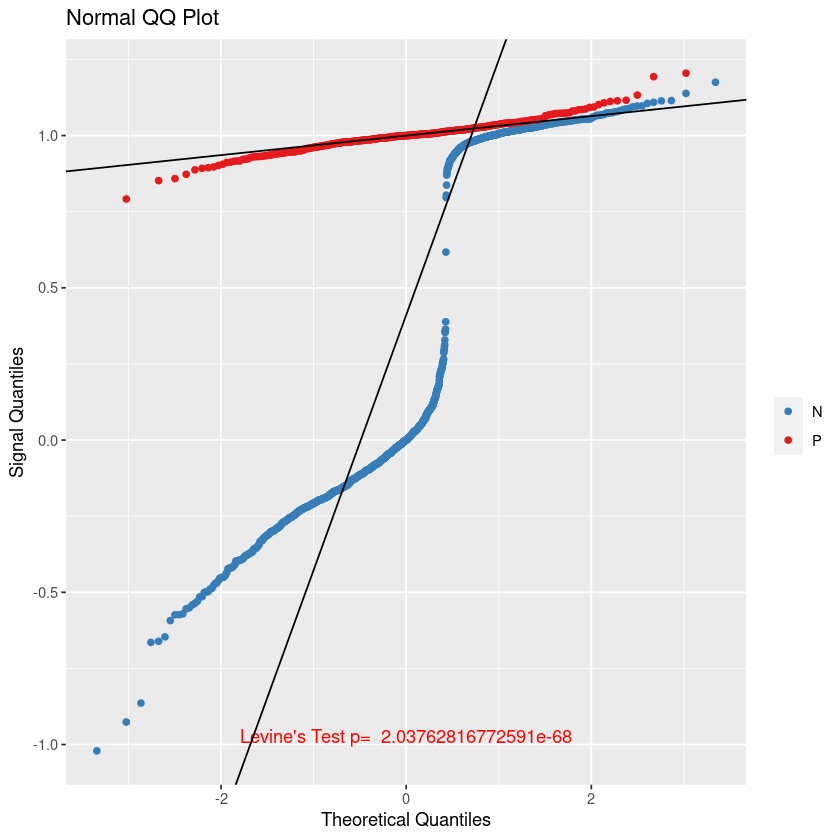

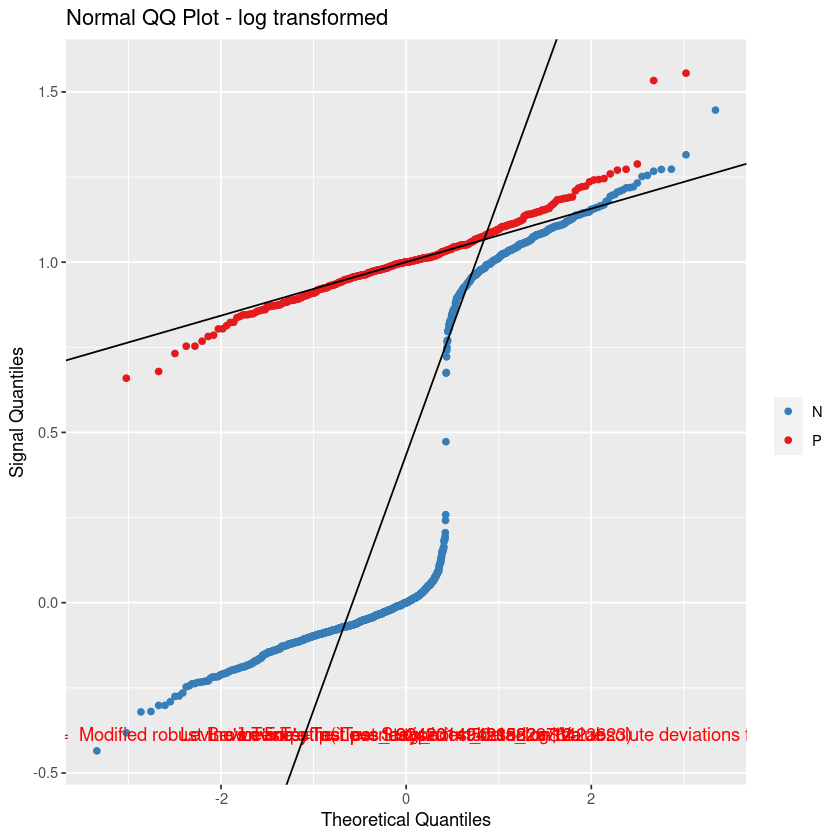

In [7]:
# QQ-plos
p1 = create_qq_plot(pos_neg_norm_data, pvar = pvar)
p2 = create_qq_plot(pos_neg_norm_data_log, "Normal QQ Plot - log transformed", pvar = vartest_log)
p1
p2

In [8]:
# this doesn't work because i didn't manage to load libraries car and ggpubr
p3 = ggarrange(p1, p2, ncol = 2, labels = "AUTO", common.legend = T, legend = "right")
ggsave(paste(analysis.dir, "QQ.jpg", sep=""), p3, "jpg", dpi=300, height = 4, width = 5)

ERROR: Error in ggarrange(p1, p2, ncol = 2, labels = "AUTO", common.legend = T, : could not find function "ggarrange"


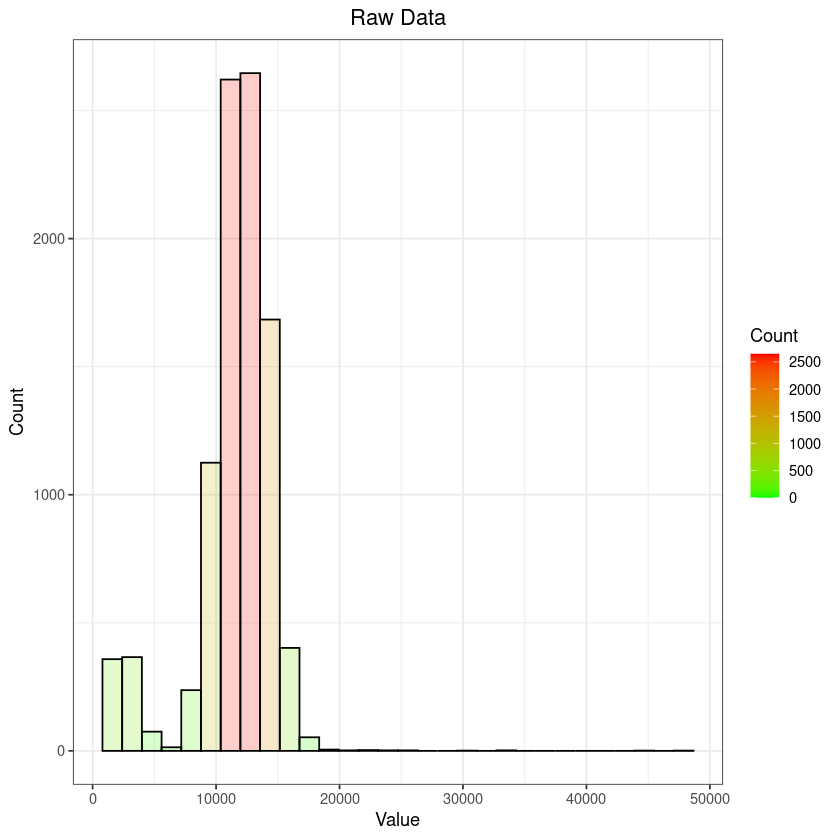

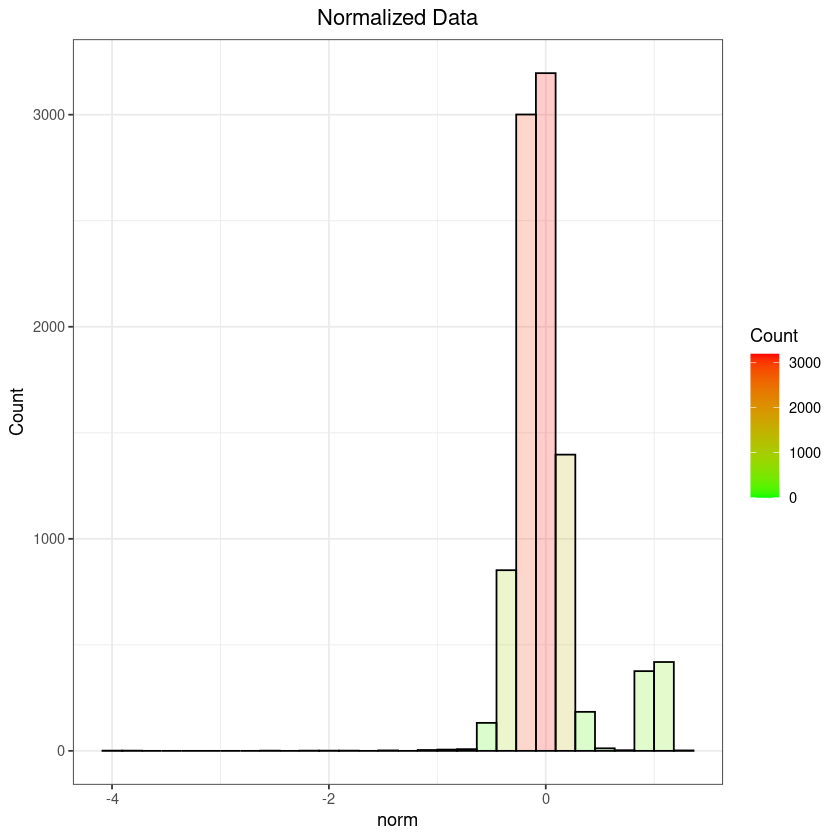

In [9]:
raw_data_hist <- create_histogram_plot(data = norm_data, x_var = "Value", fill_range = c("green", "red"), title = "Raw Data")
norm_data_hist <- create_histogram_plot(data = norm_data, x_var = "norm", fill_range = c("green", "red"), title = "Normalized Data")

raw_data_hist
norm_data_hist

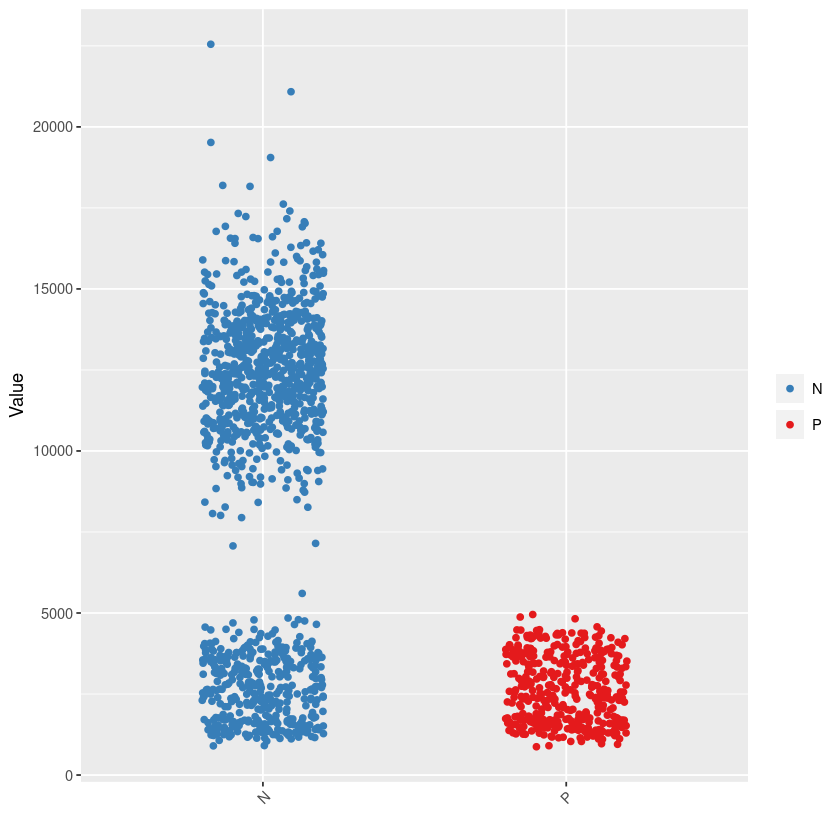

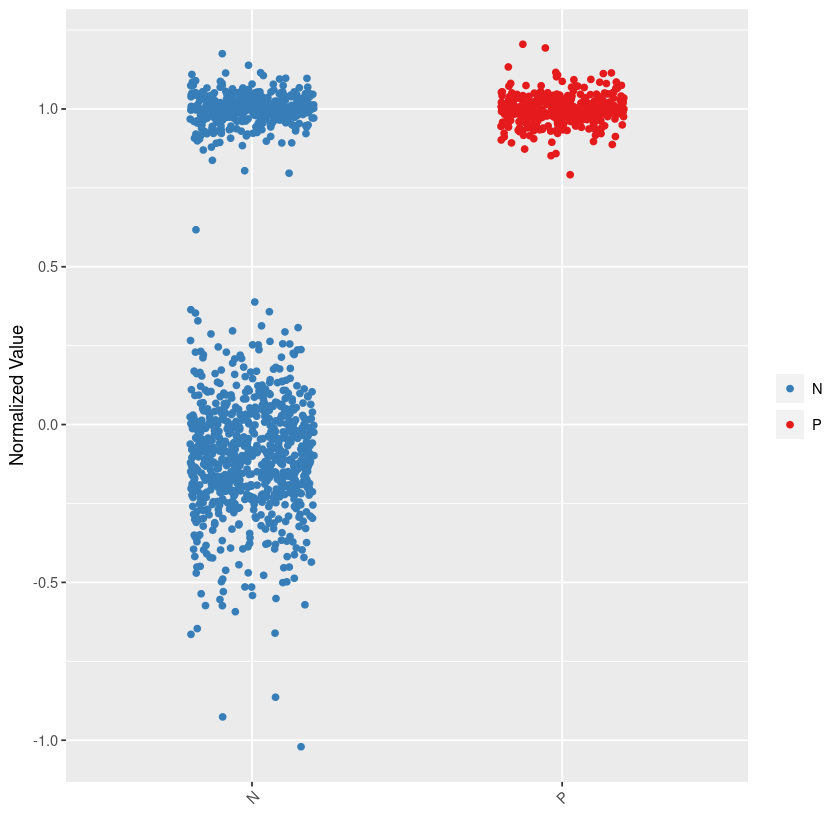

In [10]:
raw_data_scatter = create_scatterplot(pos_neg_norm_data, 'Control', 'Value', 'Value', "")
norm_data_scatter = create_scatterplot(pos_neg_norm_data, 'Control', 'norm', 'Normalized Value', "")
raw_data_scatter
norm_data_scatter

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


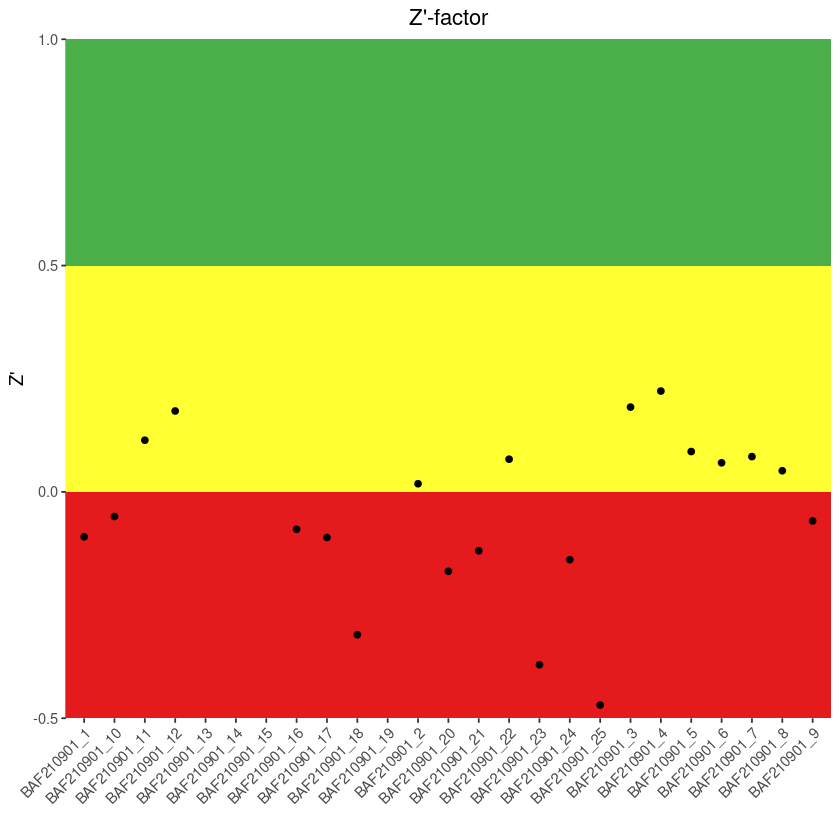

In [18]:
z_prime_plot = create_z_prime_plot(z_prime)
z_prime_plot